# Word2Vec

## Summary  

We investigated the impact  of 4 tunable hyperparameters: vector size, window size, minimum count and the max epoch. The best combination among the values we tested are – vector size: 250, window size: 35, minimum count: 10 and max epoch: 16. The best  Spearman's Rank correlation coefficient on the WordSim353  is 0.747125.  

For 4 parameters we tuned, they all improve the model performance as their values grow up, until reaching a certain optimal solution. Afterwards, the increase on the parameter values will bring down the model performance. Although there are researchers specifying certain optimal values for the Word2Vec model to have the best learning results, it is still important to tune these parameters since the data and the task may differ.  

Since I was not in a good health condition(fever), ther was no time left for me to invesigate in how to eliminate word sense ambiguity. It would be an interesting topic to look into in the future.

In [6]:
import gensim
import logging
import multiprocessing
from gensim.models import word2vec
import numpy as np
from time import time

import sys
import json
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

import evaluation

Code in the report is inspired by the word2vec.py provided with the assignment resources.  

A Word2Vec implementation based on gensim has been provided. The task is to train the given model on the Text8 corpus, and test on WordSim353 dataset.  WordSim353  is a test collection for measuring word similarity or relatedness, developed and maintained by E. Gabrilovich. The image is an example of the information contained in this dataset. The Human(mean) column indicates how similar the pair is with human review.  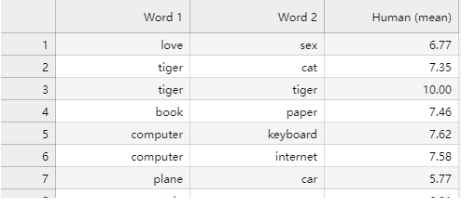


## 1.1 Word2Vec Model  

It is a shallow 2-layer neural network. The input contains all documents in our training dataset, and these texts are represented in 1-hot encoding of words. The Neurons’ amount in the hidden layer is equal to the length of the embeddings we want. That is, if  we want all our words to be vectors of length 300, then the hidden layer will contain 300 neurons.  

The output layer contains probabilities for a target word (given an input to the model, what word is expected) given a particular input. At the end of the training process, the hidden weights are treated as the word embedding. Intuitively, this can be thought of as each word having a set of n weights (300 considering the example above) “weighing” their different characteristics (an analogy we used earlier).  

Based on the document of gensim Word2Vec model, we will, in this section, investigate how vector size, window size, minimum word count and max epochs affect the learning quality.  


In [7]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)

In [8]:
data_path = './text8'
# loading dataset
sents = word2vec.Text8Corpus('text8')

## 1.2 Vector Size  

As mentioned in Section 1.1, the vector size indicates the length of the vector to represent a word. We tested vector sizes: [50, 100, 150, 200, 250, 300, 350, 400].  

Both the window size and the minimum count is set to 10. The max epoch is set to 5, which is the default value in the gensim Word2Vec model definition.  
The size of the vector can be selected according to the corpus size and the type of project. The entire corpus is scanned, and the vector creation process is performed by determining which words the target word occurs with more often. In this way, the semantic closeness of the words to each other is also revealed. The vector size for Word2Vec model commonly falls between 300-400, and according to research, the quality for vector representations improves as you increase the vector size until you reach 300 dimensions. After 300 dimensions, the quality of vectors starts to decrease. However, this 300 value could also change based on the training dataset amount and the computation power.  

Below are the diagrams of train time and the score on the test set(WordSim353). The score is Spearman's Rank correlation coefficient, a common coefficient to summarize the strength and direction (negative or positive) of a relationship between two variables.  

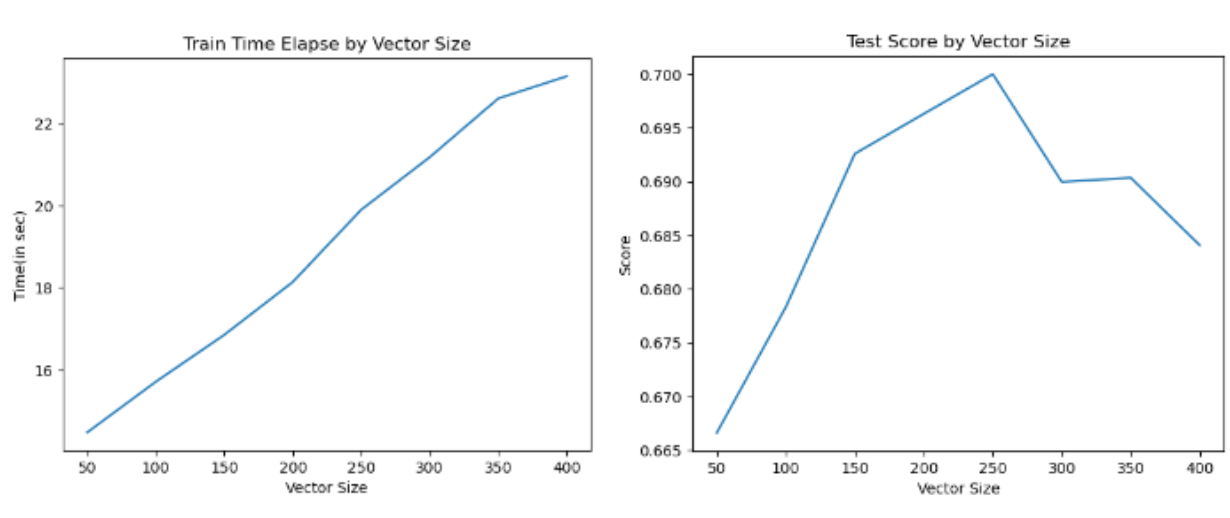  

As can be seen from the diagrams, the greater the vector size is, the longer the training will take. The model reaches the highest Spearman’s Rank correlation coefficient at the vector size of 250. Then the performance starts to decrease as the vector size gets greater. In the later experiments, we will therefore use vector size 250 for testing other parameters。)

## 1.3 Window Size  

It is the number of neighboring words that will directly affect the vector calculations of the target expression. Usually, larger window size is recommended for more topic-specific corpora, whereas a smaller one is more fit for input texts concerning more general topics and has also been proved to encode more syntactical information in the Skip-Gram variation of word2vec。  

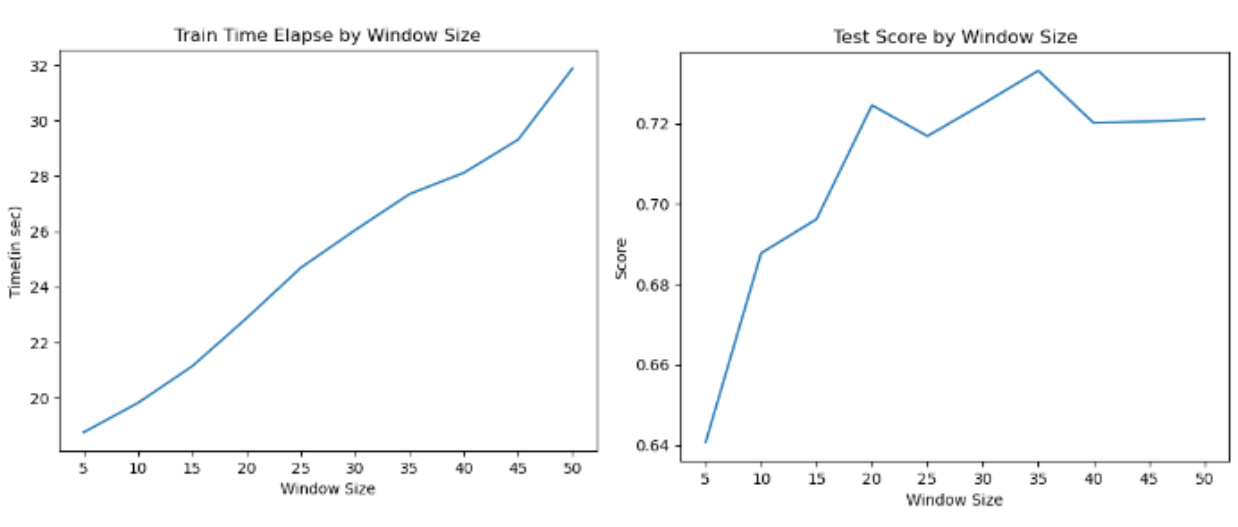    

Same as the vector size, larger window size means more training time(complexity). The performance of the model generally follows an upward  trend as the window size increases. When the window size reaches 20, small fluctuations happen on the score curve， reaches the highest score, drops down and then tends to stabilize.  The choice of the window size mainly depends on the material you are using for training. If the window size of 2 can capture the context of a word, but 5 is chosen, it will decrease the quality of the learnt model, and vice versa. The best score is when the window size is set to 35.  


## 1.4 Min Count  

Minimum count is the minimum number of occurrences of the target word in the corpus. Especially for very large corpuses, keeping this limit high increases the success even more. However, it would be more accurate to keep it small for small datasets.  Words below the minimum count frequency are dropped before training occurs.  

Minimum count values we tested are: [1, 2, 5, 7, 10, 15]. The diagrams of model performances are below.   

As the minimum count increases, the training time decreases at the same time, as more words are dropped before the actual training happens.  

Minimum count equals to 1 will create a much larger-in-memory model, with a lot of low-value, low-quality infrequent words, that takes longer to train – a loss on almost every dimension, except the completist desire to have a vector-for-every-seen-word.  On the other hand, a too large minimum count will also lead to a problem.  Ignoring too many words is a defensible choice – and most deployed systems need to be tolerant of novel unknown words.  

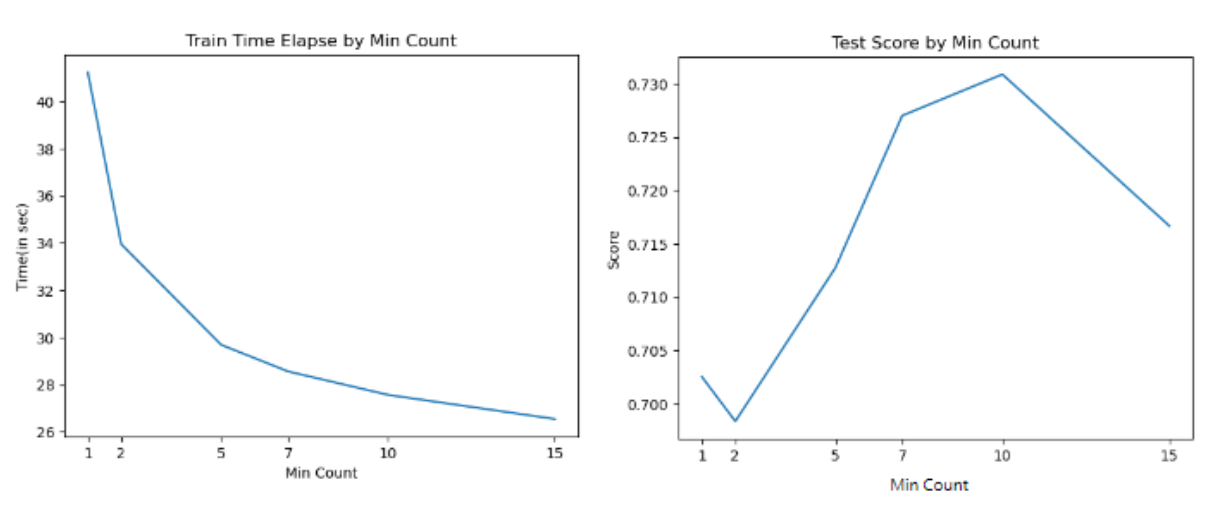  

The performance diagram also proves the above conclusion. The Spearman's Rank correlation coefficient is quite low when the minimum count is pretty small, since there are a lot of rare words in the vocabulary. The coefficient keeps climbing up until the minimum count reaches 10, then immediately follows a sharp downward trend as the minimum count gets greater. Too many words have been filtered out with a high minimum count(=15), and potentially leaving too many words unavailable at the inference stage.  

## 1.5 Max Epochs  

The hyperparameters for the Word2Vec model now are – window size: 35, vector size: 250, minimum count: 10. We will increase the training epochs and see if the model performance could be improved.  

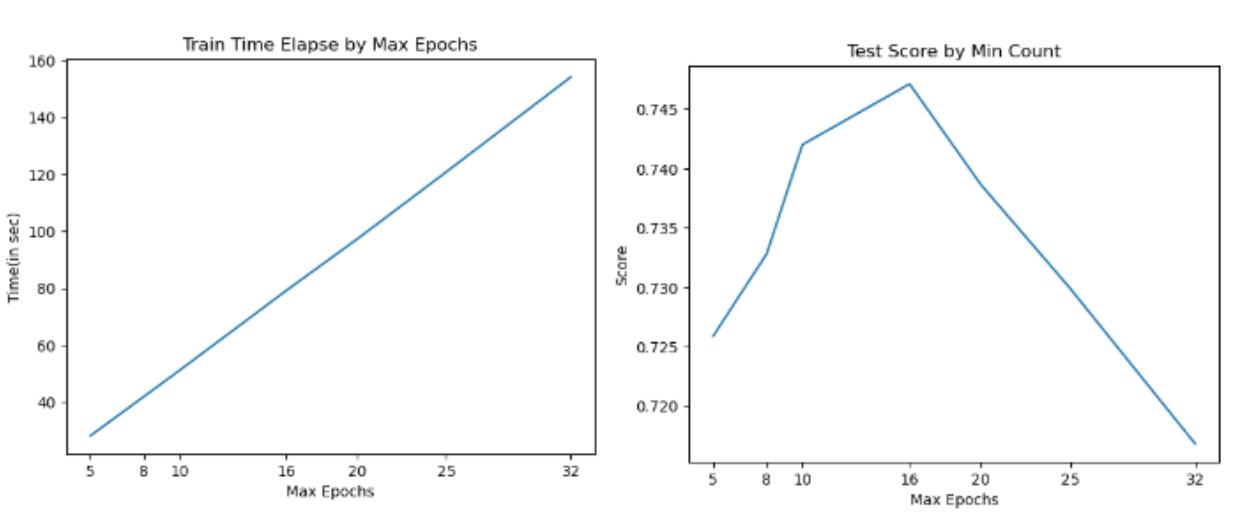  

Originally the epoch amounts we tested are: [5, 8, 16, 25, 32]. After drawing the Spearman's Rank correlation coefficient diagram, we noticed that there exists a sharp downward trend when the epoch amount is above 16, We made an assumption that the  max epoch amount that could lead to the best model solution should be in the range of [16, 25]. Therefore, we in addition tested a model with 20 epochs. The new diagram suggests that the best performance of the model could be produced when the epoch amount is set to 16. Further increasing the training epoch may result in overfitting, and the performance quality on the test set will be reduced.  



## Code for Parameter Tuning

In [9]:
iters = [16]

train_time = []
evaluation_score = []
for iter in iters:
    print("iteration count: {}".format(iter))
    t = time() # for timing the train time
    model = gensim.models.Word2Vec(sents,
                                   vector_size=250,
                                   window=35,
                                   min_count=10,
                                   epochs=iter,
                                   workers=multiprocessing.cpu_count())
    # saving to file
    model.save("word2vec_gensim_iter_{}".format(iter))
    model.wv.save_word2vec_format("word2vec_org",
                                  "vocabulary",
                                  binary=False)
    # log the train time
    train_time.append(time() - t)

    # testing on wordsim353
    sims = []
    ground_truth = []
    with open('./wordsim353/combined.csv') as f:
        for line in f.readlines()[1:]:
            l = line.strip().split(',')
            if l[0] in model.wv.key_to_index and l[1] in model.wv.key_to_index: # filter out words that are not in the vocabulary
                sims.append(model.wv.similarity(l[0], l[1])) # score the model
                ground_truth.append(float(l[2]))
    np.save('./score.npy', np.array(sims))
    np.save('./ground_truth.npy', np.array(ground_truth))

    # log the evaluation
    eval_result = evaluation.eval('score.npy')
    evaluation_score.append(eval_result['score'])

print(train_time)
print(evaluation_score)

2024-01-22 01:45:31,014 : INFO : collecting all words and their counts
2024-01-22 01:45:31,020 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types


iteration count: 16


2024-01-22 01:45:32,962 : INFO : collected 253854 word types from a corpus of 17005207 raw words and 1701 sentences
2024-01-22 01:45:32,962 : INFO : Creating a fresh vocabulary
2024-01-22 01:45:33,073 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=10 retains 47134 unique words (18.57% of original 253854, drops 206720)', 'datetime': '2024-01-22T01:45:33.073913', 'gensim': '4.3.2', 'python': '3.10.11 | packaged by Anaconda, Inc. | (main, May 16 2023, 00:55:32) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'prepare_vocab'}
2024-01-22 01:45:33,073 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=10 leaves 16561031 word corpus (97.39% of original 17005207, drops 444176)', 'datetime': '2024-01-22T01:45:33.073913', 'gensim': '4.3.2', 'python': '3.10.11 | packaged by Anaconda, Inc. | (main, May 16 2023, 00:55:32) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'prepare_vocab'}
2024-01-22 01:45:33,17

[82.52755308151245]
[0.7440505817458214]


In [ ]:
plt.figure()
plt.xticks(iters)

plt.plot(iters, train_time, linestyle='-')
plt.xlabel('Max Epochs')
plt.ylabel("Time(in sec)")
plt.title("Train Time Elapse by Max Epochs")

In [ ]:
plt.figure()
plt.xticks(iters)

plt.plot(iters, evaluation_score, linestyle='-')
plt.xlabel('Max Epochs')
plt.ylabel("Score")
plt.title("Test Score by Min Count")

### Conclusion  

We investigated the impact of 4 tunable hyperparameters: vector size, window size, minimum count and the max epoch. The best combination among the values we tested are – vector size: 250, window size: 35, minimum count: 10 and max epoch: 16. The best Spearman's Rank correlation coefficient on the WordSim353 is 0.747125.  